The general idea of this project is to assess the use of Hidden Markov Models (HMMs) to discover if dice are loaded based on observations. We will attempt to determine for each observation if there is one loaded die, two loaded dice, or if all dice are fair.

At the beginning, we will generate 1000 observations using a known transition matrix. Later, we will recover the hidden states, which are as follows:

- 0: (fair die, fair die)

- 1: (fair die, loaded die)

- 2: (loaded die, loaded die)

The image below shows the probabilities of transitions bewtween the states.

![My paper with states drawing](./screenshot.png)

**When recovering we assume no knowledge about loaded dice probabilities!**

In [414]:
import numpy as np
import matplotlib.pyplot as plt

from hmmlearn.hmm import CategoricalHMM

In [415]:
# Simulating throwing pair of dices

# Define the number of hidden states and features
n_states = 3  # Hidden states: (fair dice, fair dice), (fair dice, biased dice), (biased dice, biased dice)
n_features = 36  # Observation symbols: |{1, 2, 3, 4, 5, 6}|x|{1, 2, 3, 4, 5, 6}|

# Define start probabilities: we are starting with State 1 (fair dice, fair dice)
start_probabilities = np.array([1.0, 0.0, 0.0])

# Define transition probabilities
trans_probabilities = np.array([ 
    [0.98, 0.01, 0.01],
    [0.01, 0.98, 0.01],
    [0.00, 0.01, 0.99]    
])

# Define emission probabilities
# Each dice has values 1 to 6
fair_dice = np.full(6, 1/6)  # Equal probabilities for fair dice
biased_dice = np.array([1/7, 1/7, 1/7, 1/7, 1/7, 2/7])  # Biased dice: 6 has twice the probability of other values

# Combine to create emission probabilities for each state
emission_probabilities = np.array([
    np.outer(fair_dice, fair_dice).flatten(),  # (fair dice, fair dice)
    np.outer(fair_dice, biased_dice).flatten(),  # (fair dice, biased dice) or (biased dice, fair dice)
    np.outer(biased_dice, biased_dice).flatten()  # (biased dice, biased dice)
])

# Normalize probabilities to ensure they're valid distributions
emission_probabilities = emission_probabilities / emission_probabilities.sum(axis=1, keepdims=True)

print("Emission Probabilities:")
print(emission_probabilities)

Emission Probabilities:
[[0.02777778 0.02777778 0.02777778 0.02777778 0.02777778 0.02777778
  0.02777778 0.02777778 0.02777778 0.02777778 0.02777778 0.02777778
  0.02777778 0.02777778 0.02777778 0.02777778 0.02777778 0.02777778
  0.02777778 0.02777778 0.02777778 0.02777778 0.02777778 0.02777778
  0.02777778 0.02777778 0.02777778 0.02777778 0.02777778 0.02777778
  0.02777778 0.02777778 0.02777778 0.02777778 0.02777778 0.02777778]
 [0.02380952 0.02380952 0.02380952 0.02380952 0.02380952 0.04761905
  0.02380952 0.02380952 0.02380952 0.02380952 0.02380952 0.04761905
  0.02380952 0.02380952 0.02380952 0.02380952 0.02380952 0.04761905
  0.02380952 0.02380952 0.02380952 0.02380952 0.02380952 0.04761905
  0.02380952 0.02380952 0.02380952 0.02380952 0.02380952 0.04761905
  0.02380952 0.02380952 0.02380952 0.02380952 0.02380952 0.04761905]
 [0.02040816 0.02040816 0.02040816 0.02040816 0.02040816 0.04081633
  0.02040816 0.02040816 0.02040816 0.02040816 0.02040816 0.04081633
  0.02040816 0.0204081

# Mapping Probabilities to Observations (for output above)

The emission probabilities array represents the likelihoods of emitting specific outcomes. Since this is for the hidden state (dice, dice), here's an explanation how to map those probabilities to concrete observations:

## 1. Interpreting the Vector:
- There are 3 emission vectors in the output, one for state: (fair dice, fair dice), (fair dice, biased dice), (biased dice, biased dice), in this order.
- The emission vector consists of probabilities for each possible pair of dice outcomes (dice, dice).
- Since there are 6 possible outcomes for each die, the joint outcomes for two dice total to 36 possibilities, arranged in a flattened vector.
- (fair dice, biased dice) vs (biased dice, fair dice): when considering the probabilities, the order of the dice doesn't matter. Therefore, the scenario of having a **fair die and a biased die** is the same as having a **biased die and a fair die**.

For example:
- The first 6 probabilities correspond to dice1 = 1 and dice2 = 1 to 6, respectively.
- The next 6 probabilities correspond to dice1 = 2 and dice2 = 1 to 6, and so on.

## 2. Mapping Observations:
- Use the index of the emission vector to map it to a specific outcome. For index i:
    - dice1 = i // 6 + 1 (integer division to find the row).
    - dice2 = i % 6 + 1 (remainder to find the column).

For example:
- Index 0 corresponds to (1, 1), index 7 corresponds to (2, 2), and index 35 corresponds to (6, 6).

In [416]:
# Create the HMM
gen_model = CategoricalHMM(n_components=n_states, n_features=n_features, random_state=42, n_iter=100)
gen_model.startprob_ = start_probabilities
gen_model.transmat_ = trans_probabilities
gen_model.emissionprob_ = emission_probabilities

In [417]:
# Simulate a sequence of flips
n_flips = 10000
rolls, gen_states = gen_model.sample(n_flips)
rolls[:10]

array([[34],
       [21],
       [ 5],
       [31],
       [25],
       [34],
       [ 7],
       [ 6],
       [18],
       [10]])

## Dice Pair Mapping (for output above)

To map each roll (indices in the range 0–35) to pairs of dice results (dice1, dice2), one can use the formulas:

- dice1 = index // 6 + 1: This computes the first die's result by dividing the index by 6 and adding 1.
- dice2 = index % 6 + 1: This computes the second die's result by taking the remainder when dividing the index by 6 and adding 1.

In [418]:
gen_states

array([0, 0, 0, ..., 1, 1, 1])

## Understanding hidden states (for output above)

model_states is a vector, containing state for each given roll (roll[i] <=> model_states[i]).

- First roll - state is 0 (fair dice, fair dice)
- Second roll - same state
- Last roll - state is 2 (biased dice, biased dice)

In [419]:
# Map each roll index to dice results
dice_pairs = [(roll[0] // 6 + 1, roll[0] % 6 + 1) for roll in rolls]

states_mapping = ['(fair dice, fair dice)', '(fair dice, biased dice)', '(biased dice, biased dice)']

# Print the mapped dice results
print("Mapped Dice and State Results - top 100:")
for i in range(0, min(n_flips, 100)):
    face1, face2 = dice_pairs[i]
    state = gen_states[i]
    print('faces:  ({0}, {1})  |  state: {2}'.format(face1, face2, states_mapping[state]))

Mapped Dice and State Results - top 100:
faces:  (6, 5)  |  state: (fair dice, fair dice)
faces:  (4, 4)  |  state: (fair dice, fair dice)
faces:  (1, 6)  |  state: (fair dice, fair dice)
faces:  (6, 2)  |  state: (fair dice, fair dice)
faces:  (5, 2)  |  state: (fair dice, fair dice)
faces:  (6, 5)  |  state: (fair dice, fair dice)
faces:  (2, 2)  |  state: (fair dice, fair dice)
faces:  (2, 1)  |  state: (fair dice, fair dice)
faces:  (4, 1)  |  state: (fair dice, fair dice)
faces:  (2, 5)  |  state: (fair dice, fair dice)
faces:  (1, 6)  |  state: (fair dice, fair dice)
faces:  (3, 2)  |  state: (fair dice, fair dice)
faces:  (5, 5)  |  state: (fair dice, fair dice)
faces:  (4, 1)  |  state: (fair dice, fair dice)
faces:  (1, 2)  |  state: (fair dice, fair dice)
faces:  (2, 1)  |  state: (fair dice, fair dice)
faces:  (6, 5)  |  state: (fair dice, fair dice)
faces:  (5, 6)  |  state: (fair dice, fair dice)
faces:  (1, 4)  |  state: (fair dice, fair dice)
faces:  (3, 4)  |  state: (f

C:\Users\SimonShtock\AppData\Local\Temp\ipykernel_22164\2903586535.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


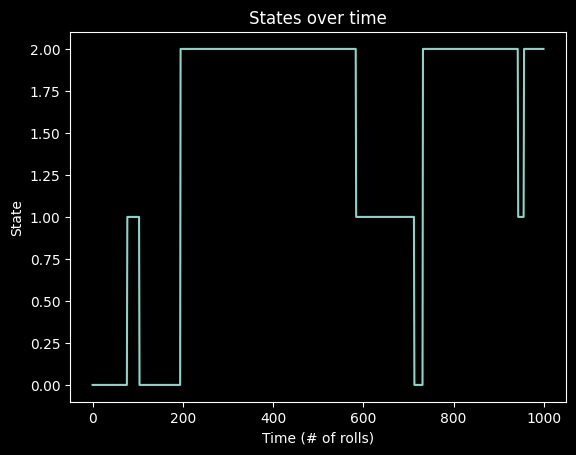

In [420]:
# plot states over time, let's just look at the first rolls for clarity
fig, ax = plt.subplots()
ax.plot(gen_states[:1000])
ax.set_title('States over time')
ax.set_xlabel('Time (# of rolls)')
ax.set_ylabel('State')
fig.show()

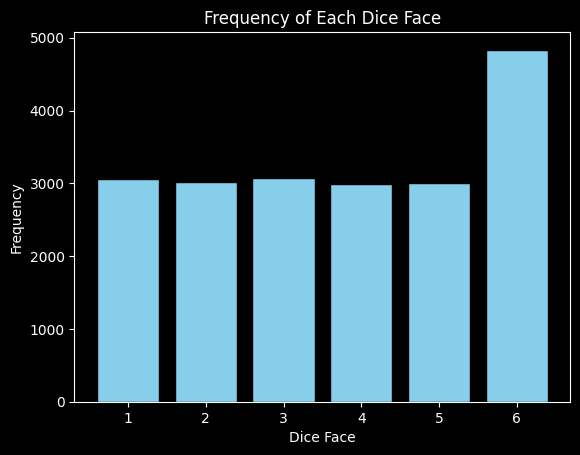

In [421]:
# Just to confirm cheating we will plot the frequencies for each dice face

# Flatten the pairs into a single list of dice outcomes
all_faces = [face for pair in dice_pairs for face in pair]

# Calculate the frequency of each dice face
face_counts = {face: all_faces.count(face) for face in range(1, 7)}

# Plot the frequencies
plt.bar(face_counts.keys(), face_counts.values(), color='skyblue', edgecolor='black')
plt.xlabel('Dice Face')
plt.ylabel('Frequency')
plt.title('Frequency of Each Dice Face')
plt.xticks(range(1, 7))  # Ensure labels for faces are from 1 to 6
plt.show()

## Now, let’s see if we can recover our hidden states, transmission matrix and emission probabilities from observations.

This process is known as unsupervised learning for HMMs, and it generally involves using algorithms like the Baum-Welch algorithm (a variant of the Expectation-Maximization algorithm).

## 1. Estimate Transition and Emission Probabilities:

- **Algorithm**: Use the **Baum-Welch Algorithm** to iteratively re-estimate the transition and emission probabilities based on the observation sequence.
- **Steps**:
    - Initialize the HMM with random or uniform probabilities for startprob_, transmat_, and emissionprob_.
    - Use the Baum-Welch algorithm to adjust the parameters to maximize the likelihood of the observed data.

In [422]:
model01 = CategoricalHMM(n_components=n_states, n_iter=100, random_state=42)

# Fit the model to the observations
model01.fit(rolls)

CategoricalHMM(n_components=3, n_features=np.int64(36), n_iter=100,
               random_state=RandomState(MT19937) at 0x118AFAC5E40)

In [423]:
model01.transmat_

array([[3.22743454e-03, 9.96462997e-01, 3.09568639e-04],
       [7.79322636e-01, 3.15727452e-02, 1.89104619e-01],
       [2.55611143e-01, 1.19665062e-01, 6.24723795e-01]])

### Evaluation of the similarity between the restored transition matrix and the true transition matrix

In [424]:
# Compute the difference matrix
diff_matrix = gen_model.transmat_ - model01.transmat_

# Measure similarity using the Frobenius norm
frobenius_norm = np.linalg.norm(diff_matrix, 'fro')
print(f"Frobenius Norm of Difference: {frobenius_norm}")

# Compute Mean Absolute Error (MAE)
mae = np.mean(np.abs(diff_matrix))
print(f"Mean Absolute Error: {mae}")

# Compute Mean Squared Error (MSE)
mse = np.mean((diff_matrix)**2)
print(f"Mean Squared Error: {mse}")


Frobenius Norm of Difference: 1.9135119602951118
Mean Absolute Error: 0.511148101492283
Mean Squared Error: 0.40683644691027127


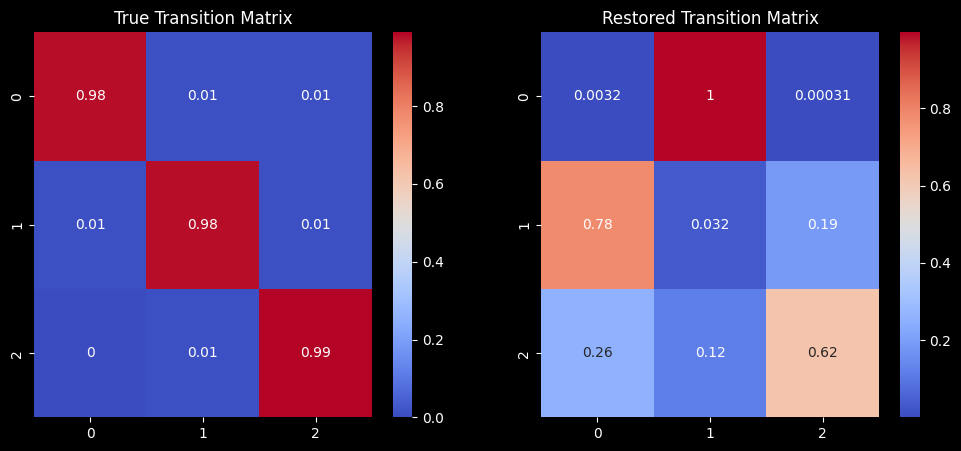

In [425]:
import seaborn as sns

# Visualize true and restored matrices
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.heatmap(gen_model.transmat_, annot=True, cmap="coolwarm", cbar=True)
plt.title("True Transition Matrix")

plt.subplot(1, 2, 2)
sns.heatmap(model01.transmat_, annot=True, cmap="coolwarm", cbar=True)
plt.title("Restored Transition Matrix")

plt.show()


In [426]:
model01.emissionprob_

array([[2.28424830e-02, 3.42432075e-02, 2.10676283e-02, 3.52147556e-02,
        2.20915400e-02, 3.07962711e-02, 1.70054083e-02, 2.24037910e-02,
        3.43371899e-02, 2.90426466e-02, 1.96700607e-02, 3.17596221e-02,
        1.12182839e-02, 2.74083819e-02, 2.69528080e-02, 1.68860495e-02,
        2.24355096e-02, 3.68841280e-02, 3.00604023e-02, 2.77861151e-02,
        1.74670028e-02, 2.46068296e-02, 2.14518588e-02, 4.34659486e-02,
        2.27647844e-02, 3.36381233e-02, 2.19771928e-02, 3.25048597e-02,
        3.03690669e-02, 2.95411294e-02, 4.55327816e-02, 3.36576055e-02,
        2.17449415e-02, 3.54642651e-02, 1.03969116e-02, 5.53104164e-02],
       [2.96000700e-02, 2.19763495e-02, 4.00132175e-02, 1.65369270e-03,
        2.39788555e-02, 4.66892745e-02, 2.49165532e-02, 3.36091078e-02,
        2.47408142e-02, 1.35190642e-02, 2.65443321e-02, 3.43078949e-02,
        3.14278177e-02, 2.88908111e-02, 2.17234487e-02, 3.82923130e-02,
        3.31257972e-02, 5.30687431e-02, 2.76416974e-02, 1.97675

### Evaluation of the similarity between the restored emission probabilities and the true emission probabilities

In [427]:
diff_emission_prob = gen_model.emissionprob_ - model01.emissionprob_

# Compute MAE
mae = np.mean(np.abs(diff_emission_prob))
print(f"Mean Absolute Error (MAE): {mae}")

# Compute MSE
mse = np.mean((diff_emission_prob)**2)
print(f"Mean Squared Error (MSE): {mse}")

Mean Absolute Error (MAE): 0.009101805070382475
Mean Squared Error (MSE): 0.0001546692277166715


### 2. Recover Hidden States:

- **Algorithm**: Use the **Viterbi Algorithm** to infer the most likely sequence of hidden states given the observation sequence.
- **Steps**:
    - Start with an initial guess for the transition and emission probabilities.
    - Compute the most probable sequence of hidden states for the given observations.

In [428]:
model = CategoricalHMM(n_components=n_states, random_state=1977)
model.fit(rolls)
    
    
# Find most likely state sequence corresponding to "rolls" (true samples), using Viterbi algorithm
log_prob, recovered_states = model.decode(rolls, algorithm='viterbi')


print("Most Likely Hidden States (first 100):")
print(recovered_states[:100])

Most Likely Hidden States (first 100):
[1 0 2 2 1 1 1 1 1 1 1 1 0 2 2 1 1 1 0 2 2 1 0 2 1 1 1 1 1 0 2 2 1 1 1 1 1
 1 1 1 1 1 0 2 1 1 0 2 2 2 1 1 1 1 0 2 1 1 1 1 1 0 2 1 1 0 2 1 1 0 2 1 1 1
 1 1 0 2 1 0 2 1 1 1 1 1 1 1 0 2 1 1 0 2 1 0 2 2 1 0]


In [429]:
accuracy = np.mean(recovered_states == gen_states)
print(f"Accuracy: {accuracy}")

Accuracy: 0.345


### Interpreting results

The accuracy we received was not very encouraging—we managed to correctly guess only 1/3 of the states. However, there's one observation that might change this: the accuracy score does not take into account the similarity between states 2 and 3, both of which are states where the casino is cheating. If we alter our research question a little bit to: "Can we tell when a casino is cheating?" we might get different results.

In order to do so, we can compare 2 artificial states: cheating (1 or 2) vs. not cheating (0). On a practical level, this could be easily achieved by converting state 2 into 1 and calculating accuracy on modified vectors.

In [430]:
recovered_states[recovered_states == 2] = 1
gen_states[gen_states == 2] = 1

accuracy = np.mean(recovered_states == gen_states)
print(f"Accuracy (cheating vs. not cheating): {accuracy}")

Accuracy (cheating vs. not cheating): 0.6848


### Final verdict

We're interested in distinguishing between "cheating" versus "not cheating" modes. We can obtain an accuracy score of 68.5%. 

I assume this result will vary for different transition matrices. 

I believe the matrix taken for the sake of my study was "convenient" because there are no frequent transitions between states.